In [61]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim as optim 
import tushare as ts 

In [62]:
"""
ts.set_token('cece2a8ee94291a9ea0aa278e8c23a92df485b1b4b059a85823c989c')
ts_pro = ts.pro_api()
# 股票代码
ts_code = '399001.SZ'
# 开始时间
start_date = '20100101'
# 结束时间
end_date = '20200101'
df = ts_pro.index_daily(
        ts_code=ts_code,
        start_date=start_date,
        end_date=end_date)
# 将获取的文件存储在本地
df.to_csv('399001.SZ.csv', index=0)
df.head()
"""

"\nts.set_token('cece2a8ee94291a9ea0aa278e8c23a92df485b1b4b059a85823c989c')\nts_pro = ts.pro_api()\n# 股票代码\nts_code = '399001.SZ'\n# 开始时间\nstart_date = '20100101'\n# 结束时间\nend_date = '20200101'\ndf = ts_pro.index_daily(\n        ts_code=ts_code,\n        start_date=start_date,\n        end_date=end_date)\n# 将获取的文件存储在本地\ndf.to_csv('399001.SZ.csv', index=0)\ndf.head()\n"

In [63]:
"""
df = pd.read_csv('APPL.csv')
# 按照时间进行排序，方便预测处理
df = df.sort_values(['trade_date'], ascending=True)
# 简要查看文件信息
df.to_csv('APPL.png', index=0)
df.head()
"""

"\ndf = pd.read_csv('APPL.csv')\n# 按照时间进行排序，方便预测处理\ndf = df.sort_values(['trade_date'], ascending=True)\n# 简要查看文件信息\ndf.to_csv('APPL.png', index=0)\ndf.head()\n"

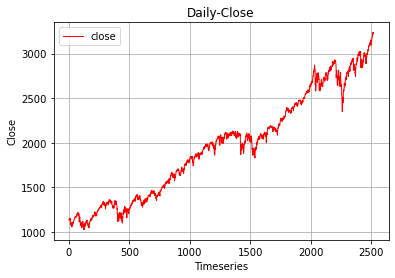

In [64]:
s_data = pd.read_csv('./Data/SPX.csv', parse_dates=True)
s_data_copy = s_data
t = 3000
plt.plot(s_data["close"][:t],'r',lw = 1)
plt.legend(["close"])
plt.grid(True)
plt.axis("tight")
plt.xlabel("Timeseries")
plt.ylabel("Close")
plt.title("Daily-Close")
plt.savefig('SPX.png')
plt.show()

In [79]:
#定义训练集
data_csv = pd.read_csv('./Data/399001.SZ.csv')
use_cols = ['close']
data_csv = data_csv [use_cols]
data_csv = data_csv.dropna()
# 为了归一化后复现原来数据
close_min = data_csv['close'].min()
close_max = data_csv['close'].max()
# 归一化处理（0，1）
data_csv=data_csv.apply(lambda x:(x-min(x))/(max(x)-min(x)))
data_csv.head()

close
0  0.588765
1  0.587309
2  0.586211
3  0.561914
4  0.564793

In [80]:
import numpy as np 
# 序列长度为5，即用前5的数据预测之后一天的数据
sequence = 30
X = []
Y = []
for i in range(data_csv.shape[0]-sequence):
    # 选择use_cols作为特征
    X.append(np.array(data_csv.iloc[i:(i+sequence)].values, dtype=np.float))
    # 选择close作为标签输出
    Y.append(np.array(data_csv.iloc[(i+sequence)],dtype=np.float))

In [81]:
trainx, trainy = X[:int(0.7*data_csv.shape[0])], Y[:int(0.7*data_csv.shape[0])]
testx, testy = X[int(0.7*data_csv.shape[0]):], Y[int(0.7*data_csv.shape[0]):]

print(len(trainx))
print(len(testx))

1701
700


In [82]:
torch.manual_seed(1)

In [83]:
# list -> numpy
trainx = np.array(trainx)
trainy = np.array(trainy)
testx = np.array(testx)
testy = np.array(testy)


trainx = trainx.reshape(-1,1, sequence)  # (seq_size, batch_size, feature_size)
trainy = trainy.reshape(-1,1, 1)
testx = testx.reshape(-1, 1,sequence)  # (seq_size, batch_size, feature_size)

print('------------')
print(trainx.shape)
print(trainy.shape)
print(testx.shape)

# numpy -> torch
trainx = torch.from_numpy(trainx)
trainy = torch.from_numpy(trainy)
testx = torch.from_numpy(testx)
testy = torch.from_numpy(testy)


print('trainx size: ', trainx.size())
print('trainy size: ', trainy.size())
print('testx size: ', testx.size())
print('testy size: ', testy.size())

------------
(1701, 1, 30)
(1701, 1, 1)
(700, 1, 30)
trainx size:  torch.Size([1701, 1, 30])
trainy size:  torch.Size([1701, 1, 1])
testx size:  torch.Size([700, 1, 30])
testy size:  torch.Size([700, 1])


In [84]:
input_size = 30
hidden_size = 30
num_layers = 1
output_size = 1

In [85]:
class LSTM(nn.Module):

    def __init__(self, input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers):
        super(LSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)  # input, size (seq_len, batch, input_size)
        s, b, h = output.shape  # output, size (seq_len, batch, hidden_size)
        output = output.view(s*b, h)
        output = self.fc(output)
        output = output.view(s, b, -1)  # 把形状改回来
        return output

model = LSTM()
print(model)

LSTM(
  (lstm): LSTM(30, 30)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)


In [86]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [87]:
trainx = Variable(trainx).float()
trainy = Variable(trainy).float()
testx = Variable(testx).float()
testy = Variable(testy).float()
print (trainx.shape)
print (trainy.shape)
print (testx.shape)
print (testy.shape)

torch.Size([1701, 1, 30])
torch.Size([1701, 1, 1])
torch.Size([700, 1, 30])
torch.Size([700, 1])


In [88]:
for epoch in range(100):                   
    out = model(trainx)
    loss = loss_function(out, trainy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  

    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))

Epoch: 10, Loss:0.05426
Epoch: 20, Loss:0.01148
Epoch: 30, Loss:0.00628
Epoch: 40, Loss:0.00567
Epoch: 50, Loss:0.00456
Epoch: 60, Loss:0.00434
Epoch: 70, Loss:0.00404
Epoch: 80, Loss:0.00392
Epoch: 90, Loss:0.00374
Epoch: 100, Loss:0.00360


torch.Size([1701, 1, 1])


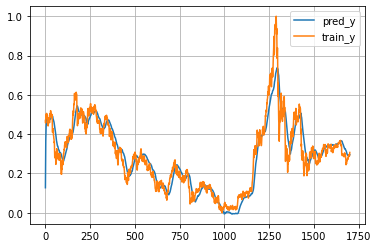

In [90]:
model = model.eval()
output_train=model(trainx)
print(output_train.shape)

plt.plot(output_train.data.numpy().reshape(1701,1), label='pred_y')
plt.plot(trainy.reshape(1701,1), label='train_y')
plt.grid(True)
plt.axis("tight")
plt.legend()
plt.show()

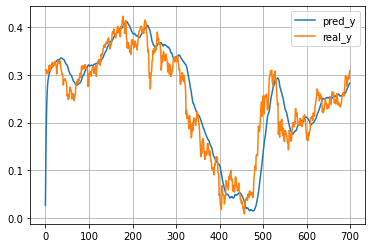

In [91]:
# 测试集输入模型进行预测
model = model.eval() # 让model变成测试模式（训练效果图）
output_test = model(testx)

plt.plot(output_test.data.numpy().reshape(700,1),label='pred_y')
plt.plot(testy.reshape(700,1),label='real_y')
plt.legend()
plt.grid(True)
plt.axis("tight")
plt.savefig("RNN-LSTM-Prediction(SZSE).png")
plt.show()

In [92]:
pred = output_test.data.numpy().reshape(700,1)
real = testy.data.numpy().reshape(700,1)
print(pred.shape)
print(real.shape)

(700, 1)
(700, 1)


In [93]:
mse = mean_squared_error(pred, real)
rmse = math.sqrt(mean_squared_error(pred, real))
mae = mean_absolute_error(pred, real)
print('mean_squared_error: %.6f' % mse)
print('root_mean_squared_error: %.6f' % rmse)
print('mean_absolute_error: %.6f' % mae)

mean_squared_error: 0.001706
root_mean_squared_error: 0.041310
mean_absolute_error: 0.029372
